In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [2]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T_*_N_20k-*.prof.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)

df = pd.concat(li, axis=0, ignore_index=True)


# Clean the data

In [3]:
#remove info from other traces
df_refined = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df_refined['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df_refined = df_refined.astype(float)

In [4]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [5]:
filter = ( (df_refined['task_class_id'] >= 0 ) & ( df_refined['task_class_id'] <= 3 ) & ( df_refined['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df_refined = df_refined[filter]
df_refined.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
0,223077.0,8059762.0,2.0,1.0,0.0,2.0,5120000.0,0.0,7836.685
1,8073626.0,15523889.0,2.0,1.0,0.0,2.0,5120000.0,0.0,7450.263
2,15541947.0,22565897.0,2.0,1.0,0.0,2.0,5120000.0,0.0,7023.950
3,22577284.0,28244345.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5667.061
4,28263291.0,34534578.0,2.0,1.0,0.0,2.0,5120000.0,0.0,6271.287


In [6]:
df_class = {}
for i in df_refined['task_class_id'].unique():
    df_class[i] = df_refined[df_refined['task_class_id'] == i]
    

### remove outliers

In [7]:
df_class_new = {}
for i in df_refined['task_class_id'].unique():
    title = df_class_name[i]
    Q1 = df_class[i]['exec_time'].quantile(0.25)
    Q3 = df_class[i]['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_class[i]['exec_time'] >= Q1 - 1.5 * IQR) & (df_class[i]['exec_time'] <= Q3 + 1.5 *IQR)
    df_class_new[i] = df_class[i].loc[filter]
    df_class_new[i] = df_class_new[i].astype(float)
    #plt.figure()
    #sns.displot(df_new, x="exec_time", hue='total_data_size', binwidth=5e2)
    #plt.title(title)
#plt.show()

## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [8]:

for i in df_refined['task_class_id'].unique():
    Q1 = df_class_new[i]['exec_time'].quantile(0.25)
    Q3 = df_class_new[i]['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    df_class_new[i]['cache_likelihood'] = np.where(df_class_new[i]['exec_time'] < Q1, 1, 0)

In [9]:
df_class_new[3].tail()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
1642695,3.940688e+11,3.940689e+11,4.0,3.0,0.0,3.0,240000.0,294.0,95.878,0
1642696,3.940694e+11,3.940695e+11,4.0,3.0,0.0,3.0,240000.0,288.0,98.266,0
1642699,3.941286e+11,3.941287e+11,4.0,3.0,0.0,3.0,240000.0,44.0,116.168,0
1642700,3.941752e+11,3.941753e+11,4.0,3.0,0.0,3.0,240000.0,67.0,121.725,0
1642702,3.941754e+11,3.941755e+11,4.0,3.0,0.0,3.0,240000.0,31.0,99.821,0


In [10]:
df_class_new[3][df_class_new[3]['cache_likelihood'] == 1]#.total_data_siz

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
201626,7.689097e+09,7.689180e+09,4.0,3.0,0.0,3.0,240000.0,1365992.0,82.704,1
201627,7.689197e+09,7.689280e+09,4.0,3.0,0.0,3.0,240000.0,1365253.0,82.678,1
201628,7.689297e+09,7.689380e+09,4.0,3.0,0.0,3.0,240000.0,1364174.0,83.527,1
201629,7.689397e+09,7.689480e+09,4.0,3.0,0.0,3.0,240000.0,1363027.0,82.334,1
201630,7.689504e+09,7.689587e+09,4.0,3.0,0.0,3.0,240000.0,1362380.0,82.886,1
...,...,...,...,...,...,...,...,...,...,...
1642248,3.856341e+11,3.856342e+11,4.0,3.0,0.0,3.0,240000.0,2388.0,84.581,1
1642314,3.865957e+11,3.865957e+11,4.0,3.0,0.0,3.0,240000.0,364.0,83.361,1
1642401,3.887343e+11,3.887344e+11,4.0,3.0,0.0,3.0,240000.0,1905.0,85.010,1
1642424,3.890048e+11,3.890049e+11,4.0,3.0,0.0,3.0,240000.0,356.0,83.764,1


## combine all the class into a single dataframe

In [11]:
frames = []
df_refined_new = pd.DataFrame()
for i in df_refined['task_class_id'].unique():
    frames.append(df_class_new[i])
df_refined_new = pd.concat(frames) 

In [12]:
df_refined_new.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
4463,3583742.0,4012791.0,2.0,1.0,0.0,2.0,320000.0,0.0,429.049,0
4464,4020469.0,4374617.0,2.0,1.0,0.0,2.0,320000.0,0.0,354.148,0
4465,4382256.0,4712048.0,2.0,1.0,0.0,2.0,320000.0,0.0,329.792,0
4467,5498788.0,5849588.0,2.0,1.0,0.0,2.0,320000.0,0.0,350.800,0
4468,5856491.0,6182545.0,2.0,1.0,0.0,2.0,320000.0,0.0,326.054,0


In [13]:
df_refined_new.tail()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
1627964,2.153399e+11,2.153400e+11,4.0,0.0,0.0,1.0,80000.0,1520875.0,76.175,0
1636406,3.149225e+11,3.149226e+11,4.0,0.0,0.0,1.0,80000.0,357911.0,71.838,1
1636742,3.187716e+11,3.187716e+11,4.0,0.0,0.0,1.0,80000.0,328509.0,71.290,1
1640089,3.579441e+11,3.579442e+11,4.0,0.0,0.0,1.0,80000.0,79507.0,70.967,1
1641656,3.784492e+11,3.784492e+11,4.0,0.0,0.0,1.0,80000.0,24389.0,72.643,0


## change some columns to catogrical data

In [14]:
#df_refined_new = pd.get_dummies(df_refined_new, prefix='task_pool_', columns=['taskpool_id'], prefix_sep='')
df_refined_new = pd.get_dummies(df_refined_new, prefix='task_class_', columns=['task_class_id'], prefix_sep='')

In [15]:
df_refined_new.head()

,begin,end,taskpool_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood,task_class_0.0,task_class_1.0,task_class_2.0,task_class_3.0
4463,3583742.0,4012791.0,2.0,0.0,2.0,320000.0,0.0,429.049,0,0,1,0,0
4464,4020469.0,4374617.0,2.0,0.0,2.0,320000.0,0.0,354.148,0,0,1,0,0
4465,4382256.0,4712048.0,2.0,0.0,2.0,320000.0,0.0,329.792,0,0,1,0,0
4467,5498788.0,5849588.0,2.0,0.0,2.0,320000.0,0.0,350.800,0,0,1,0,0
4468,5856491.0,6182545.0,2.0,0.0,2.0,320000.0,0.0,326.054,0,0,1,0,0


### Divide the data to training and test sets

In [16]:
train_dataset = df_refined_new.sample(frac=0.8, random_state=0)
test_dataset = df_refined_new.drop(train_dataset.index)
print(train_dataset.shape)
print(test_dataset.shape)

(1083800, 13)
(270950, 13)


## Divide the data into trainig features and labels

In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('exec_time')
test_labels = test_features.pop('exec_time')

In [18]:
train_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
begin,1083800.0,1.886775e+11,1.130167e+11,358878.0,8.979160e+10,1.853030e+11,2.857006e+11,3.942686e+11
end,1083800.0,1.886775e+11,1.130167e+11,983849.0,8.979168e+10,1.853031e+11,2.857007e+11,3.942687e+11
taskpool_id,1083800.0,3.965139e+00,2.617368e-01,2.0,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
chore_id,1083800.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nb_data_items,1083800.0,2.946711e+00,2.260269e-01,1.0,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
total_data_size,1083800.0,2.380027e+05,3.932343e+04,80000.0,2.400000e+05,2.400000e+05,2.400000e+05,6.400000e+05
priority,1083800.0,4.277263e+05,7.871398e+05,0.0,2.979700e+04,1.011550e+05,4.342470e+05,7.880602e+06
cache_likelihood,1083800.0,2.498985e-01,4.329543e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
task_class_0.0,1083800.0,2.195977e-04,1.481721e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
task_class_1.0,1083800.0,3.448053e-02,1.824600e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


# -------------------Build the multi variate full model------------------------------

## select the required features from the list

In [19]:
## for the time being select only total_data_size, priority, diff task_classes and diff taskpools

#train_features = train_features.drop('end', 1)
#train_features = train_features.drop('end', 1)
train_features = train_features.drop(['chore_id', 'begin', 'end', 'taskpool_id'], axis = 1)
test_features = test_features.drop(['chore_id', 'begin', 'end', 'taskpool_id'], axis = 1)



In [20]:
train_features.head()

,nb_data_items,total_data_size,priority,cache_likelihood,task_class_0.0,task_class_1.0,task_class_2.0,task_class_3.0
768489,3.0,240000.0,79571.0,0,0,0,0,1
597001,3.0,240000.0,84498.0,1,0,0,0,1
1161690,3.0,240000.0,3735.0,0,0,0,0,1
762723,3.0,240000.0,108167.0,0,0,0,0,1
1480625,2.0,160000.0,358214.0,0,0,0,1,0


In [21]:
normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer = layers.Normalization(input_shape=[1,], axis=None)
normalizer.adapt(np.array(train_features))

2022-04-13 15:39:23.971415: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:


LR_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [26]:
LR_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse', metrics=[tf.keras.metrics.Accuracy()])
print(full_model.metrics_names)

['loss', 'accuracy']


In [28]:
checkpoint_path = "LR_model_all_class.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
lr_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Train the model

In [29]:
history = LR_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    callbacks=[lr_callback])


Epoch 1: saving model to LR_model_all_class.ckpt

Epoch 2: saving model to LR_model_all_class.ckpt

Epoch 3: saving model to LR_model_all_class.ckpt

Epoch 4: saving model to LR_model_all_class.ckpt

Epoch 5: saving model to LR_model_all_class.ckpt

Epoch 6: saving model to LR_model_all_class.ckpt

Epoch 7: saving model to LR_model_all_class.ckpt

Epoch 8: saving model to LR_model_all_class.ckpt

Epoch 9: saving model to LR_model_all_class.ckpt

Epoch 10: saving model to LR_model_all_class.ckpt

Epoch 11: saving model to LR_model_all_class.ckpt

Epoch 12: saving model to LR_model_all_class.ckpt

Epoch 13: saving model to LR_model_all_class.ckpt

Epoch 14: saving model to LR_model_all_class.ckpt

Epoch 15: saving model to LR_model_all_class.ckpt

Epoch 16: saving model to LR_model_all_class.ckpt

Epoch 17: saving model to LR_model_all_class.ckpt

Epoch 18: saving model to LR_model_all_class.ckpt

Epoch 19: saving model to LR_model_all_class.ckpt

Epoch 20: saving model to LR_model_all_

In [30]:
LR_model.save('./LR_model_all_class')

2022-04-13 16:59:29.399491: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./LR_model_all_class/assets


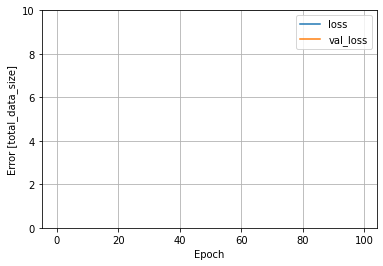

In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [total_data_size]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [32]:
full_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 26
Trainable params: 9
Non-trainable params: 17
_________________________________________________________________


In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,173.783676,0.000001,169.541412,0.000000,95
96,173.800537,0.000000,170.902405,0.000000,96
97,173.785629,0.000000,169.623505,0.000009,97
98,173.582260,0.000000,170.169540,0.000000,98
99,173.930023,0.000000,170.453751,0.000000,99


## Test the Model 

In [34]:
#test_results = {}
#test_results['full_model'] = full_model.evaluate(
#    test_features, test_labels, verbose=0)
#loss, acc = full_model.evaluate(test_features, test_labels, verbose=2)
#print(test_results['full_model'])

loss = full_model.evaluate(test_features, test_labels, batch_size=128)
print(loss)

2117/2117 [==============================] - 3s 1ms/step - loss: 171.4485 - accuracy: 0.0000e+00
[171.44850158691406, 0.0]


In [35]:
# nb_data_items total_data_size priority cache_likelihood task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0

print(full_model.predict([3.0, 3840000.0, 9908.0, 0, 0, 0, 0, 1]))
print(df_class_new[3]['exec_time'].min())
print(df_class_new[3]['exec_time'].max())

[[2937.698]]
75.754
126.72200000000001


## Train using DNN

In [36]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [37]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                576       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [38]:
checkpoint_path = "DNN_model_all_class.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
dnn_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100,
    callbacks=[dnn_callback])


Epoch 1: saving model to DNN_model_all_class.ckpt

Epoch 2: saving model to DNN_model_all_class.ckpt

Epoch 3: saving model to DNN_model_all_class.ckpt

Epoch 4: saving model to DNN_model_all_class.ckpt

Epoch 5: saving model to DNN_model_all_class.ckpt

Epoch 6: saving model to DNN_model_all_class.ckpt

Epoch 7: saving model to DNN_model_all_class.ckpt

Epoch 8: saving model to DNN_model_all_class.ckpt

Epoch 9: saving model to DNN_model_all_class.ckpt

Epoch 10: saving model to DNN_model_all_class.ckpt

Epoch 11: saving model to DNN_model_all_class.ckpt

Epoch 12: saving model to DNN_model_all_class.ckpt

Epoch 13: saving model to DNN_model_all_class.ckpt

Epoch 14: saving model to DNN_model_all_class.ckpt

Epoch 15: saving model to DNN_model_all_class.ckpt

Epoch 16: saving model to DNN_model_all_class.ckpt

Epoch 17: saving model to DNN_model_all_class.ckpt

Epoch 18: saving model to DNN_model_all_class.ckpt

Epoch 19: saving model to DNN_model_all_class.ckpt

Epoch 20: saving mod

In [ ]:
DNN_model.save('DNN_all_class')


In [ ]:
plot_loss(history)

In [59]:
# nb_data_items total_data_size priority cache_likelihood task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0


print(dnn_model.predict([3.0, 3840000.0, 9908.0, 0, 0, 0, 0, 1]))
print(df_class_new[3]['exec_time'].min())
print(df_class_new[3]['exec_time'].max())

[[4783.525]]
3621.516
50086.282


In [60]:

print(dnn_model.predict([3, 15360000.0, 9663.0, 1,  0, 0, 0, 1]))
print(test_labels.min())
print(test_labels.max())

[[43244.06]]
1093.827
50060.432


## Predict from a different trace

In [61]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T_100_N_20k-*.prof.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)

df_diff = pd.concat(li, axis=0, ignore_index=True)

In [62]:
df_diff_refined = df_diff[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df_diff_refined['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df_diff_refined = df_diff_refined.astype(float)

filter = ( (df_diff_refined['task_class_id'] >= 0 ) & ( df_diff_refined['task_class_id'] <= 3 ) & ( df_diff_refined['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df_diff_refined = df_diff_refined[filter]
df_diff_refined.head()
df_diff_refined = df_diff_refined.dropna()

In [63]:
df_diff_refined.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
0,940579.0,1076420.0,2.0,1.0,0.0,2.0,80000.0,0.0,2197.400
1,1085521.0,1542369.0,2.0,2.0,0.0,1.0,80000.0,0.0,2173.239
2,1716414.0,1962939.0,2.0,2.0,0.0,1.0,80000.0,0.0,1536.859
3,1969834.0,2721077.0,2.0,2.0,0.0,1.0,80000.0,0.0,1864.424
4,2728069.0,3652902.0,2.0,2.0,0.0,1.0,80000.0,0.0,1305.226


In [67]:
print(dnn_model.predict([1, # nb_data_items
                         80000.0, #total_data_size  
                         0, #priority
                         1, #cache_likelihood
                         #task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0
                         0, 0, 1, 0]))

[[1326.577]]


In [68]:
print(dnn_model.predict([1, # nb_data_items
                         80000.0, #total_data_size  
                         0, #priority
                         0, #cache_likelihood
                         #task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0
                         0, 0, 1, 0]))

[[1275.438]]


In [40]:
df_diff_class_1 = df_diff_refined[df_diff_refined['task_class_id'] == 1]
print(df_diff_class_1['exec_time'].min())
print(df_diff_class_1['exec_time'].max())
print(sum(df_diff_class_1['exec_time']) / len(df_diff_class_1['exec_time']))

1.928
149259.303
102656.5046090426


## Train using random forest

In [90]:
# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_features, label="my_label")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_features, label="my_label")

NameError: name 'tfdf' is not defined